# Vision‑Transformer Baseline – Spatter/Streak Segmentation

## Imports

In [9]:
import os

import h5py
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as T
from PIL import Image
from torch.utils.data import Dataset
from transformers import AutoModelForSemanticSegmentation, SegformerImageProcessor


## Dataset helper

In [2]:
class PeregrineDataset(Dataset):
    """Lazy-loading Dataset for the Peregrine L-PBF build."""

    def __init__(self, h5_path, layers=None, size=512, augment=False):
        self.h5_path = h5_path      # keep only the path here
        self.h5      = None         # opened lazily in each worker
        self.layers  = list(layers) if layers is not None else None

        tf_list = [T.Resize(size)]
        if augment:
            tf_list.extend([T.RandomHorizontalFlip(),
                            T.RandomVerticalFlip()])
        tf_list.append(T.ToTensor())         # → float in [0,1]
        self.tf = T.Compose(tf_list)

    def _lazy_init(self):
        """Open the HDF5 file the first time this worker accesses it."""
        if self.h5 is None:
            self.h5 = h5py.File(self.h5_path, "r")
            self.imgs = self.h5["slices/camera_data/visible/0"]
            self.sp   = self.h5["slices/segmentation_results/8"]   # spatter
            self.st   = self.h5["slices/segmentation_results/3"]   # streaking

    def __len__(self):
        self._lazy_init()
        return len(self.layers) if self.layers is not None else len(self.imgs)

    def __getitem__(self, idx):
        self._lazy_init()

        layer_idx = self.layers[idx] if self.layers is not None else idx

        # image → RGB, mask → binary uint8
        img   = Image.fromarray(self.imgs[layer_idx]).convert("RGB")
        mask  = (self.sp[layer_idx] | self.st[layer_idx]).astype(np.uint8)

        img_t  = self.tf(img)                                 # [3,H,W]
        mask_t = self.tf(Image.fromarray(mask)).squeeze(0)    # [H,W] 0/1

        return img_t, mask_t

## Quick sanity‑check visual

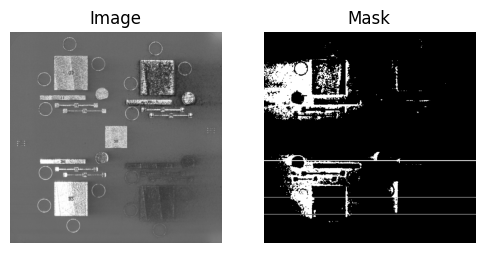

In [3]:

ds = PeregrineDataset(
	'../data/2021-04-16 TCR Phase 1 Build 2.hdf5', 
	layers=range(0, 100, 10), 
	size=512, 
	augment=True
)
img, mask = ds[3]
plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plt.imshow(img.permute(1,2,0)); plt.title('Image'); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(mask, cmap='gray'); plt.title('Mask'); plt.axis('off')
plt.show()


## DataLoader

In [4]:
loader = torch.utils.data.DataLoader(
    ds,
    batch_size=4,
    shuffle=True,
    num_workers=4,
    persistent_workers=True # avoids reopen every epoch
)

## Load SegFormer‑B0 and swap decode head

In [10]:
os.environ["HF_HUB_DISABLE_PROGRESS_BARS"] = "1"
from transformers.utils import logging as hf_log

hf_log.set_verbosity_error()

# 1. load processor & model
processor = SegformerImageProcessor.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512"
)
model = AutoModelForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512",
    id2label={0: "anomaly"},      # ← ONE label
    ignore_mismatched_sizes=True,
)

# 2. replace ONLY the final 1×1 conv
in_ch = model.decode_head.classifier.in_channels      # 256 for B0
model.decode_head.classifier = nn.Conv2d(in_ch, 1, 1) # 1-channel logits
model.config.num_labels = 1
model.config.label2id = {"anomaly": 0}

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  

## Simple train_one_epoch helper

In [6]:
import contextlib


def train_one_epoch(model, loader, device="cpu", lr=3e-4):
    model.train()
    opt = torch.optim.AdamW(model.parameters(), lr=lr)

    use_cuda = device.startswith("cuda")
    scaler   = (
        torch.amp.GradScaler(device_type="cuda") if use_cuda
        else None
    )

    inter = union = loss_sum = 0.0
    n_batches = 0

    for imgs, masks in loader:
        imgs, masks = imgs.to(device), masks.to(device)

        ctx = (
            torch.amp.autocast(device_type="cuda") if use_cuda
            else contextlib.nullcontext()
        )
        with ctx:
            out = model(pixel_values=imgs).logits               # [B, 1, 128, 128]
            logits = torch.nn.functional.interpolate(
                out, size=masks.shape[-2:], mode="bilinear", align_corners=False
            ).squeeze(1)                                        # [B, 512, 512]

            loss = torch.nn.functional.binary_cross_entropy_with_logits(
                logits, masks.float()
            )
        opt.zero_grad(set_to_none=True)
        if use_cuda:
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()
        else:
            loss.backward()
            opt.step()

        # IoU bookkeeping
        preds = (torch.sigmoid(logits) > 0.5)
        inter += torch.logical_and(preds, masks).sum().item()
        union += torch.logical_or(preds, masks).sum().item()

        loss_sum  += loss.item()
        n_batches += 1

    mean_loss = loss_sum / n_batches
    mean_iou  = inter / (union + 1e-6)
    return mean_loss, mean_iou

## Kick off 1‑epoch demo training

In [7]:
ds = PeregrineDataset('../data/2021-04-16 TCR Phase 1 Build 2.hdf5', size=512)
print(ds[0][0].shape) # should be torch.Size([3, 512, 512])

torch.Size([3, 512, 512])


In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
loss, iou = train_one_epoch(model, loader, device=device)
print(f"Done ▸ loss={loss:.4f}  |  mIoU={iou:.3f}")

Done ▸ loss=0.6874  |  mIoU=0.135
